In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-02-09 10:09:00.021464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64:
2022-02-09 10:09:00.021541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [33]:
def ctc_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

def conv2D_batchnorm(*args, **kwargs):
    return keras.Sequential([
        layers.Conv2D(*args, **kwargs),
        layers.BatchNormalization(),
        layers.ReLU()
    ])

def basic_block(channel_out):
    return keras.Sequential([
        conv2D_batchnorm(
            channel_out//4, (1, 1), padding="same"
        ),
        conv2D_batchnorm(
            channel_out//4, (3, 1), padding="same"
        ),
        conv2D_batchnorm(
            channel_out//4, (1, 3), padding="same"
        ),
        conv2D_batchnorm(
            channel_out//4, (1, 1), padding="same"
        ),
    ])


In [76]:
class global_context(layers.Layer):
    def __init__(self, ksize, strides):
        super().__init__()
        self.ksize = ksize
        self.strides = strides
    
    def call(self, channel_in):
        x = layers.AveragePooling2D(
            pool_size=self.ksize, strides=self.strides, padding="same"
        )(channel_in)

        cx = layers.Lambda(lambda e: tf.math.square(e))(x)
        cx = layers.Lambda(lambda e: tf.math.reduce_mean(e))(cx)

        out = layers.Lambda(
            lambda e: tf.math.divide(e[0], e[1])
        )([x, cx])

        return out

def lprnet(
    n_classes,
    shape=(24, 94, 3),
):
    input_layer = layers.Input(shape)
    x1 = layers.Conv2D(
        64, (3, 3), strides=1, padding="same"
    )(input_layer)
    x = layers.BatchNormalization()(x1)
    x = layers.ReLU()(x)

    print(x.shape)
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding="same")(x)
    x2 = basic_block(128)(x)
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(1, 2), padding="same")(x2)
    x3 = basic_block(256)(x)
    x = basic_block(256)(x3)
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(1, 2), padding="same")(x)
    x = layers.Dropout(0.5)(x)

    print(x.shape)
    x = layers.Conv2D(
        256, (4, 1), strides=1, padding="same"
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dropout(0.5)(x)

    print(x.shape)
    x = layers.Conv2D(
        n_classes, (1, 13), padding="same"
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Global Context
    cx = layers.Lambda(lambda e: tf.math.square(e))(x)
    cx = layers.Lambda(lambda e: tf.math.reduce_mean(e))(cx)
    x0  = layers.Lambda(
        lambda e: tf.math.divide(e[0], e[1])
    )([x, cx])

    x1 = global_context(
        ksize=[1, 4],
        strides=[1, 4],
    )(input_layer)
    x2 = global_context(
        ksize=[1, 4],
        strides=[1, 4],
    )(x2)
    x3 = global_context(
        ksize=[1, 2],
        strides=[1, 2],
    )(x3)
    print(x0.shape, x1.shape)

    x = layers.Lambda(
        lambda e: tf.concat([e[0], e[1], e[2], e[3]], 3)
    )([x0, x1, x2, x3])
    x = layers.Conv2D(
        n_classes,
        kernel_size=(1,1),
        strides=(1,1),
    )(x)
    logits = layers.Lambda(
        lambda x: tf.math.reduce_mean(x, axis=1)
    )(x)
    output_layer = layers.Softmax()(logits)



    return keras.Model(input_layer, output_layer)

In [77]:
CHARS = ['京', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑',
         '苏', '浙', '皖', '闽', '赣', '鲁', '豫', '鄂', '湘', '粤',
         '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', '宁',
         '新',
         '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
         'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K',
         'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
         'W', 'X', 'Y', 'Z','_'
         ]

CHARS_DICT = {char:i for i, char in enumerate(CHARS)}
N_OUTPUTS = len(CHARS) + 1

print(f"N_OUTPUTS: {N_OUTPUTS}")

model = lprnet(N_OUTPUTS)
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(
    1e-3, 
    decay_steps=500,
    decay_rate=0.995,
    staircase=True
)
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate_scheduler
    ),
    loss=ctc_loss
)

N_OUTPUTS: 67
(None, 24, 94, 64)
(None, 24, 24, 64)
(None, 24, 24, 256)
(None, 24, 24, 67) (None, 24, 24, 3)


In [5]:
import os
import cv2

TRAIN = "clean_data/ccpd_train"
VAL = "clean_data/ccpd_val"


def read_dir(fpath):
    data, labels = [], []
    for fname in os.listdir(fpath):
        img = cv2.imread(os.path.join(fpath, fname))
        img = cv2.resize(img, (94, 24))/256
        data.append(img)

        # Get LPN
        lpn = fname.split('.')[0]
        lpn = lpn.split('-')[1]
        lpn = lpn.split('_')
        lpn = [int(l) for l in lpn]
        labels.append(lpn)
    
    print(f"Done reading {fpath}")

    return (
        tf.convert_to_tensor(data),
        tf.convert_to_tensor(labels)
    )

train_data, train_labels = read_dir(TRAIN)
val_data, val_labels = read_dir(VAL)

Done reading clean_data/ccpd_train
Done reading clean_data/ccpd_val


In [6]:
train_data[0].shape

TensorShape([24, 94, 3])

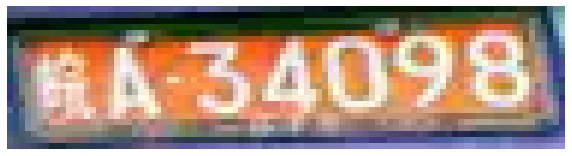

In [7]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))
plt.axis("off")
plt.imshow(train_data[0])

In [78]:
print([CHARS[l] for l in train_labels[0]])

['皖', 'A', '3', '4', '0', '9', '8']


In [79]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 24, 94, 3)]  0           []                               
                                                                                                  
 conv2d_481 (Conv2D)            (None, 24, 94, 64)   1792        ['input_33[0][0]']               
                                                                                                  
 batch_normalization_479 (Batch  (None, 24, 94, 64)  256         ['conv2d_481[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 re_lu_480 (ReLU)               (None, 24, 94, 64)   0           ['batch_normalization_479[0

In [80]:
callbacks=[
    keras.callbacks.EarlyStopping(
        monitor="val_loss", mode="min", patience=10
    )
]

model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
157/157 [==============================] - 118s 735ms/step - loss: 23.6769 - val_loss: 42.8549
Epoch 2/50
 77/157 [=============>................] - ETA: 50s - loss: 14.5184

KeyboardInterrupt: 